In [ ]:
pip install comet_ml

In [1]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="api key",
  project_name="project-name",
  workspace="workspace-name",
  log_graph=True, # Can be True or False.
  auto_metric_logging=True, # Can be True or False
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/swaroop/ire-project/9e2a3f5bc85f4d728d71258df2c5d38c



In [3]:
experiment.set_name("HIP_distilled_roberta_bilstm-v1")

In [ ]:
%pip install transformers
%pip install numpy
%pip install tensorflow
%pip install scikit-learn
%pip install pandas

In [1]:
from transformers import TFRobertaModel, RobertaConfig, RobertaTokenizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import os
import random
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import random
import sys
import math
from scipy import stats
from scipy.spatial import distance
import random
import os


BERT_MODEL = "roberta-base"  # Specify the RoBERTa model
MAX_LENGTH = 128
TEST_SIZE = 0.15
SEED = 42

USE_ATT = True

BERT_DROPOUT = 0.2
LSTM_UNITS = 512
DENSE_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_DROPOUT = 0.2
EPOCHS = 10 #(Default 10)
BATCH_SIZE = 32

def tokenize(sentences, tokenizer):
    input_ids, input_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=False)  # Roberta doesn't use token_type_ids
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])

    return (np.asarray(input_ids, dtype='int32'),
            np.asarray(input_masks, dtype='int32'))

    ## Define base Roberta configs
# config = RobertaConfig(dropout=BERT_DROPOUT,
#                        attention_dropout=BERT_DROPOUT,
#                        output_attentions=True)

config = RobertaConfig.from_pretrained(BERT_MODEL,
                                       output_hidden_states=False,
                                       attention_probs_dropout_prob =BERT_DROPOUT,
                                       output_attentions = True)
config.output_hidden_states = False
transformer_model = TFRobertaModel.from_pretrained(BERT_MODEL, config=config)

# Freeze the pre-trained layers for fine-tuning
for layer in transformer_model.layers[:3]:
    layer.trainable = False

# Defining tokenizer
tokenizer = RobertaTokenizer.from_pretrained(BERT_MODEL,
                                             add_special_tokens=True,
                                             max_length=MAX_LENGTH,
                                             pad_to_max_length=True)






Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [2]:
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

random_seed(SEED)

In [3]:
# Roberta BiLSTM

In [4]:
input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH, ),
                                     name='input_token',
                                     dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH, ),
                                       name='masked_token',
                                       dtype='int32')
embedding_layer = transformer_model(input_ids_in,
                                    attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(LSTM_UNITS,
                         return_sequences=True,
                         dropout=LSTM_DROPOUT,
                         recurrent_dropout=LSTM_DROPOUT,
                         kernel_initializer='normal'))(embedding_layer)
if USE_ATT:
    X = tf.keras.layers.Attention(use_scale=True)([X, X])  # Use attention.
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(DENSE_UNITS,
                          activation='relu',
                          kernel_initializer='normal')(X)
X = tf.keras.layers.Dropout(DENSE_DROPOUT)(X)
X = tf.keras.layers.Dense(
    1,
    activation='linear',  # Can be with activation="sigmoid" here.
    kernel_initializer='normal')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)
model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # Treat HIP as a regression problem
    metrics=['acc', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [4]:
# Roberta RCNN

In [6]:
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D

# Create the model
input_ids_in = Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

# Bi-directional LSTM layer
X_lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedding_layer)

# Convolutional layer
X_conv = Conv1D(filters=128, kernel_size=2, activation='relu')(X_lstm)  # Apply CNN on LSTM output

# Global Max Pooling layer
X_pool = GlobalMaxPooling1D()(X_conv)

# Dense layers
X = Dense(DENSE_UNITS, activation='relu')(X_pool)
X = Dropout(DENSE_DROPOUT)(X)
X = Dense(1, activation='linear')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [3]:
# Roberta RCNN with attention

In [6]:
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Attention, Concatenate
# Inputs
input_ids_in = Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

# Transformer Model for Embedding
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

# Bi-directional LSTM layer
X_lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedding_layer)

# Convolutional layer
X_conv = Conv1D(filters=128, kernel_size=2, activation='relu')(X_lstm)  # Apply CNN on LSTM output

# Attention layer
USE_ATT = True  # set to True or False
if USE_ATT:
    X_att = Attention(use_scale=True)([X_conv, X_conv])
    # Combining original convolution outputs and attention outputs
    X_combined = Concatenate(axis=-1)([X_conv, X_att])
    X_pool = GlobalMaxPooling1D()(X_combined)
else:
    X_pool = GlobalMaxPooling1D()(X_conv)

# Dense layers
X = Dense(DENSE_UNITS, activation='relu')(X_pool)
X = Dropout(DENSE_DROPOUT)(X)
X = Dense(1, activation='linear')(X)  # regression output

# Final model
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [7]:
import pandas as pd
input_data = pd.read_csv("hate_norm_with_span.csv")

In [8]:


intensity_value = []
hate_sentences = []

for i in range(len(input_data)):
    intensity_value.append(int(input_data['Original_Intensity'][i]))
    hate_sentences.append(input_data['Sentence'][i])
    intensity_value.append(int(input_data['Normalized_Intensity'][i]))
    hate_sentences.append(input_data['Normalized_Sentence'][i])

c = list(zip(intensity_value, hate_sentences))
random.shuffle(c)
intensity_value, hate_sentences = zip(*c)

X_tr, X_te, y_tr, y_te = train_test_split(hate_sentences,
                                          intensity_value,
                                          test_size=TEST_SIZE,
                                          random_state=1)

train_input_ids, train_input_masks = tokenize(
    X_tr, tokenizer)
test_input_ids, test_input_masks = tokenize(
    X_te, tokenizer)
y_tr = np.asarray(y_tr)
y_te = np.asarray(y_te)

  0%|          | 0/5145 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 909/909 [00:00<00:00, 3862.08it/s]


In [9]:
model.fit(x=[train_input_ids, train_input_masks],
          y=y_tr,
          epochs=10,
          validation_split=0.15,
          batch_size=BATCH_SIZE)

print("TEST split", TEST_SIZE)
results = model.evaluate(x=[test_input_ids, test_input_masks], y=y_te)
print(results)
result = model.predict(x=[test_input_ids, test_input_masks])
result = np.array(result, dtype=np.float)
result = result.flatten()
print("pear", stats.pearsonr(result, y_te))
print("cosine", 1 - distance.cosine(result, y_te))

Epoch 1/10
137/137 [==============================] - 80s 430ms/step - loss: 4.9822 - accuracy: 0.0055 - root_mean_squared_error: 2.2321 - val_loss: 2.9347 - val_accuracy: 0.0091 - val_root_mean_squared_error: 1.7131
Epoch 2/10
137/137 [==============================] - 55s 398ms/step - loss: 3.1444 - accuracy: 0.0055 - root_mean_squared_error: 1.7732 - val_loss: 2.2909 - val_accuracy: 0.0091 - val_root_mean_squared_error: 1.5136
Epoch 3/10
137/137 [==============================] - 55s 404ms/step - loss: 2.7462 - accuracy: 0.0055 - root_mean_squared_error: 1.6572 - val_loss: 1.9207 - val_accuracy: 0.0091 - val_root_mean_squared_error: 1.3859
Epoch 4/10
137/137 [==============================] - 56s 407ms/step - loss: 2.5087 - accuracy: 0.0055 - root_mean_squared_error: 1.5839 - val_loss: 1.9579 - val_accuracy: 0.0091 - val_root_mean_squared_error: 1.3993
Epoch 5/10
137/137 [==============================] - 56s 408ms/step - loss: 2.1811 - accuracy: 0.0055 - root_mean_squared_error: 1.

<ipython-input-9-ba1e461bdfe1>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.array(result, dtype=np.float)


In [11]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/swaroop/ire-project/fb91926badda4dbcbfd1a2ebe29b11b7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc                                         : 0.006883891765028238
COMET INFO:     batch_acc [140]                             : (0.0, 0.0625)
COMET INFO:     batch_loss [140]                            : (1.4923210144042969, 32.256107330322266)
COMET INFO:     batch_root_mean_squared_error [140]         : (1.221605896949768, 5.679445743560791)
COMET INFO:     epoch_duration [10]                         : (185.18815105499993, 226.32476023100003)
COMET INFO:     loss [10]                                   : (1.6018230915

In [12]:
# Model architecture

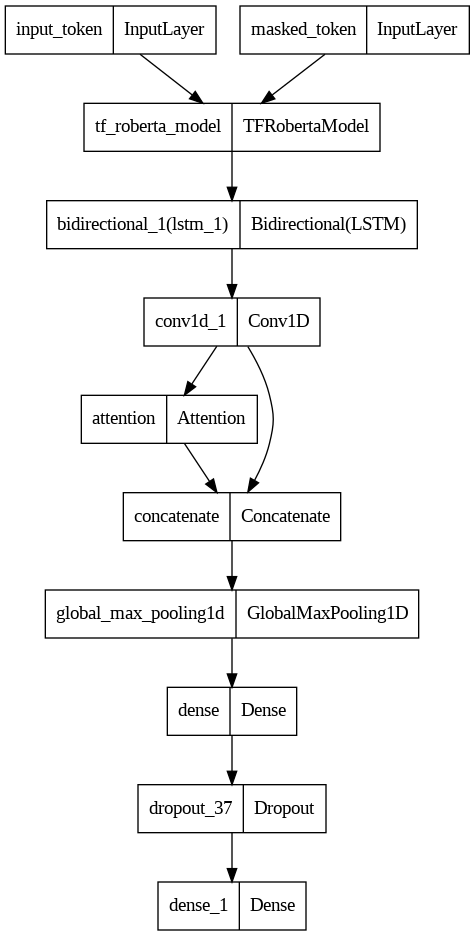

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file='model_rcnn_orig.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [5]:
# Roberta BiLSTM CNN

In [2]:
experiment.set_name("HIP_roberta_rcnn")

In [8]:
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Concatenate
from transformers import TFBertModel
import tensorflow as tf

# Set some parameters
MAX_LENGTH = 128
LSTM_UNITS = 512
DENSE_UNITS = 64
DENSE_DROPOUT = 0.2

# Load the BERT model
#transformer_model = TFBertModel.from_pretrained("bert-base-uncased")

# Create the model
input_ids_in = Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

# Bi-directional LSTM layer
X_lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedding_layer)

# Apply a pooling layer to the LSTM outputs
X_lstm = GlobalMaxPooling1D()(X_lstm)

# Convolutional layer
X_conv = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding_layer)

# Global Max Pooling layer
X_pool = GlobalMaxPooling1D()(X_conv)

# Concatenation of all layers
X_concat = Concatenate(axis=1)([X_lstm, X_pool])

# Dense layers
X = Dense(DENSE_UNITS, activation='relu')(X_concat)
X = Dropout(DENSE_DROPOUT)(X)
X = Dense(1, activation='linear')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

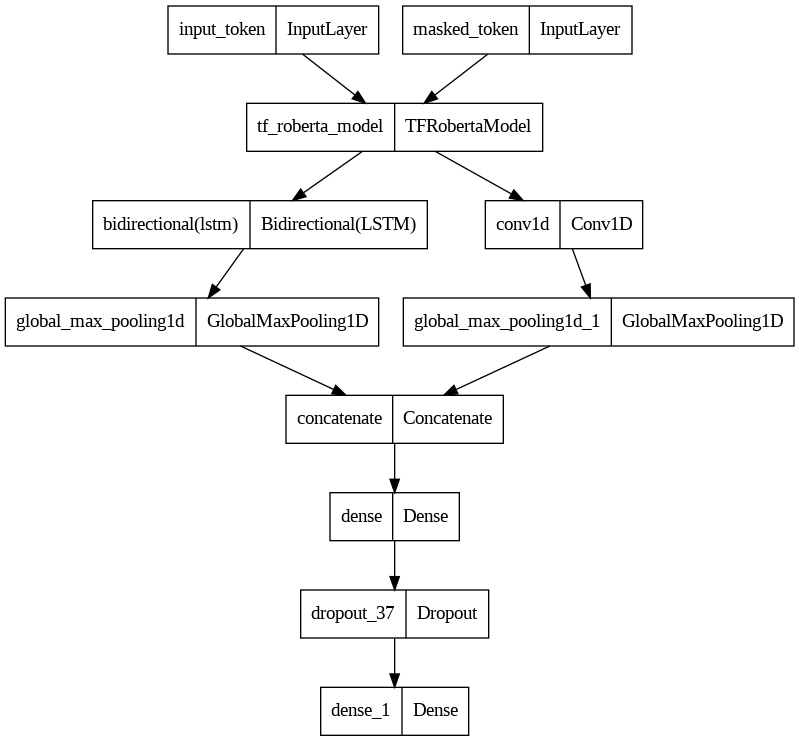

In [9]:
tf.keras.utils.plot_model(
    model,
    to_file='model_rcnn.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [10]:
model.fit(x=[train_input_ids, train_input_masks],
          y=y_tr,
          epochs=10,
          validation_split=0.1,
          batch_size=BATCH_SIZE)

print("TEST split", TEST_SIZE)
results = model.evaluate(x=[test_input_ids, test_input_masks], y=y_te)
print(results)
result = model.predict(x=[test_input_ids, test_input_masks])
result = np.array(result, dtype=np.float)
result = result.flatten()
print("pear", stats.pearsonr(result, y_te))
print("cosine", 1 - distance.cosine(result, y_te))

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/10
137/137 [==============================] - 79s 411ms/step - loss: 3.9931 - accuracy: 0.0071 - root_mean_squared_error: 1.9983 - val_loss: 3.1254 - val_accuracy: 0.0041 - val_root_mean_squared_error: 1.7679
Epoch 2/10
137/137 [==============================] - 51s 376ms/step - loss: 2.5815 - accuracy: 0.0071 - root_mean_squared_error: 1.6067 - val_loss: 3.4392 - val_accuracy: 0.0041 - val_root_mean_squared_error: 1.8545
Epoch 3/10
137/137 [==============================] - 51s 375ms/step - loss: 2.1994 - accuracy: 0.0071 - root_mean_squared_error: 1.4830 - val_loss: 2.4508 - val_accuracy: 0.0041 - val_root_mean_squared_error: 1.5655
Epoch 4/10
137/137 [==============================] - 51s 375ms/step - loss: 1.8737 - accuracy: 0.0071 - root_mean_squared_error: 1.3688 - val_loss: 2.1506 - val_accuracy: 0.0041 - val_root_mean_squared_error: 1.4665
Epoch 5/10
137/137 [==============================] - 51s 376ms/step - loss: 1.7357 - accuracy: 0.0071 - root_mean_squared_error: 1.

<ipython-input-10-6ddcb2ade1ec>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.array(result, dtype=np.float)


In [11]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/swaroop/ire-project/9e2a3f5bc85f4d728d71258df2c5d38c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy                                    : 0.007113354746252298
COMET INFO:     batch_accuracy [140]                        : (0.0, 0.014204545877873898)
COMET INFO:     batch_loss [140]                            : (0.8959447145462036, 38.09366226196289)
COMET INFO:     batch_root_mean_squared_error [140]         : (0.9465435743331909, 6.172006130218506)
COMET INFO:     epoch_duration [10]                         : (50.57714053499967, 79.4649717479997)
COMET INFO:     loss [10]                                   : (1